<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_MoGVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.8 MB/s eta 0:00:00


In [2]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "vae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
    "mogvae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/mogvae_models.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
vae_models.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.
mogvae_models.py downloaded successfully.


In [4]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import vae_models
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
import mogvae_models
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from vae_models import standVAE
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data
from mogvae_models import MoGVAE

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.72 GB


In [6]:
import torch
import torch.optim as optim
import numpy as np



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data(file_names, num_points=num_points, device=device)
print(len(data_loader))
# MoGVAEモデル構築
vae = MoGVAE(n_in_out=3 * num_points, n_z=3, n_components=2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-5)

9


In [8]:
epochs=5000
interval=100

rec_error_record = []
reg_error_record = []
total_error_record = []
z_list = []
for i in range(epochs):
    vae.train()
    loss_rec = 0
    loss_reg = 0
    loss_total = 0


    for k, (x,) in enumerate(data_loader):
            # xをdeviceに移動
            x = x.to(device)
            x = x.squeeze(0)

            # VAEの出力と損失を計算
            y, z = vae(x)  #
            lrec, lreg = vae.loss(y, x)

            # 損失の合計を計算
            loss = lrec + lreg
            loss_rec += lrec.item()
            loss_reg += lreg.item()
            loss_total += loss.item()

            # 最適化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 最終エポックでzを収集
            if i == epochs - 1:
                z_list.append(z.cpu().detach().numpy())

    # 平均を計算
    loss_rec /=  (k + 1)
    loss_reg /=  (k + 1)
    loss_total /=  (k + 1)

    # ログの記録
    rec_error_record.append(loss_rec)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    # 指定間隔でのログ出力
    if i % interval == 0:
        print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

# 最終エポック後に z_list を保存
if len(z_list) > 0:
    z_array = np.array(z_list)
    np.save("z_list_final.npy", z_array)
    print(f"z_list saved with shape: {z_array.shape}")
else:
    print("Warning: z_list is empty. Nothing was saved.")

Epoch:0 Loss_Rec:5788.941080729167 Loss_Reg:0.01637370056576199 Loss_Total:5788.957465277777
Epoch:100 Loss_Rec:1330.064717610677 Loss_Reg:31.664681964450413 Loss_Total:1361.7294040256077
Epoch:200 Loss_Rec:1146.6404825846355 Loss_Reg:25.400818718804253 Loss_Total:1172.0413275824653
Epoch:300 Loss_Rec:1140.6939629448784 Loss_Reg:17.507287237379288 Loss_Total:1158.2012600368923
Epoch:400 Loss_Rec:1140.5459120008682 Loss_Reg:13.63442940182156 Loss_Total:1154.1803181966145
Epoch:500 Loss_Rec:1141.1219550238716 Loss_Reg:10.69955031077067 Loss_Total:1151.821506076389
Epoch:600 Loss_Rec:1138.8897433810764 Loss_Reg:9.119032118055555 Loss_Total:1148.008782280816
Epoch:700 Loss_Rec:1140.3179728190105 Loss_Reg:7.82327938079834 Loss_Total:1148.1412489149307
Epoch:800 Loss_Rec:1137.0639512803818 Loss_Reg:6.856598377227783 Loss_Total:1143.9205390082466
Epoch:900 Loss_Rec:1136.5001898871528 Loss_Reg:6.007672309875488 Loss_Total:1142.5078667534722
Epoch:1000 Loss_Rec:1136.0653618706597 Loss_Reg:6.198

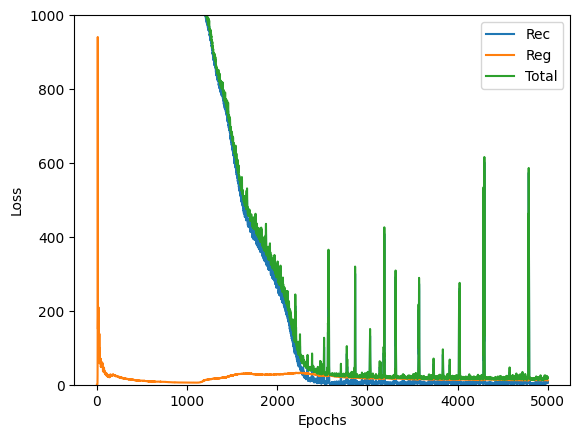

Model weights have been saved!


In [9]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
torch.save(vae.state_dict(), '/content/drive/MyDrive/chair/MoGVAE_Np5000_MSE_0216.pth')
print("Model weights have been saved!")

In [10]:
print(z_list) # z mu logvar

[array([2.8877318 , 1.0675466 , 0.10872145], dtype=float32), array([ 2.2309866, -1.2281804, -2.1297169], dtype=float32), array([ 2.8338475 , -0.33018818, -0.9275109 ], dtype=float32), array([0.91109216, 2.341888  , 1.8735822 ], dtype=float32), array([-0.76966375, -1.8180045 , -2.775497  ], dtype=float32), array([-1.965665 , -1.1079115, -1.9865768], dtype=float32), array([2.2772555, 1.7906601, 1.2670466], dtype=float32), array([ 0.7603069, -1.784197 , -2.2437985], dtype=float32), array([-0.5499335,  2.5367935,  2.4111714], dtype=float32)]


# 再構成形状の可視化

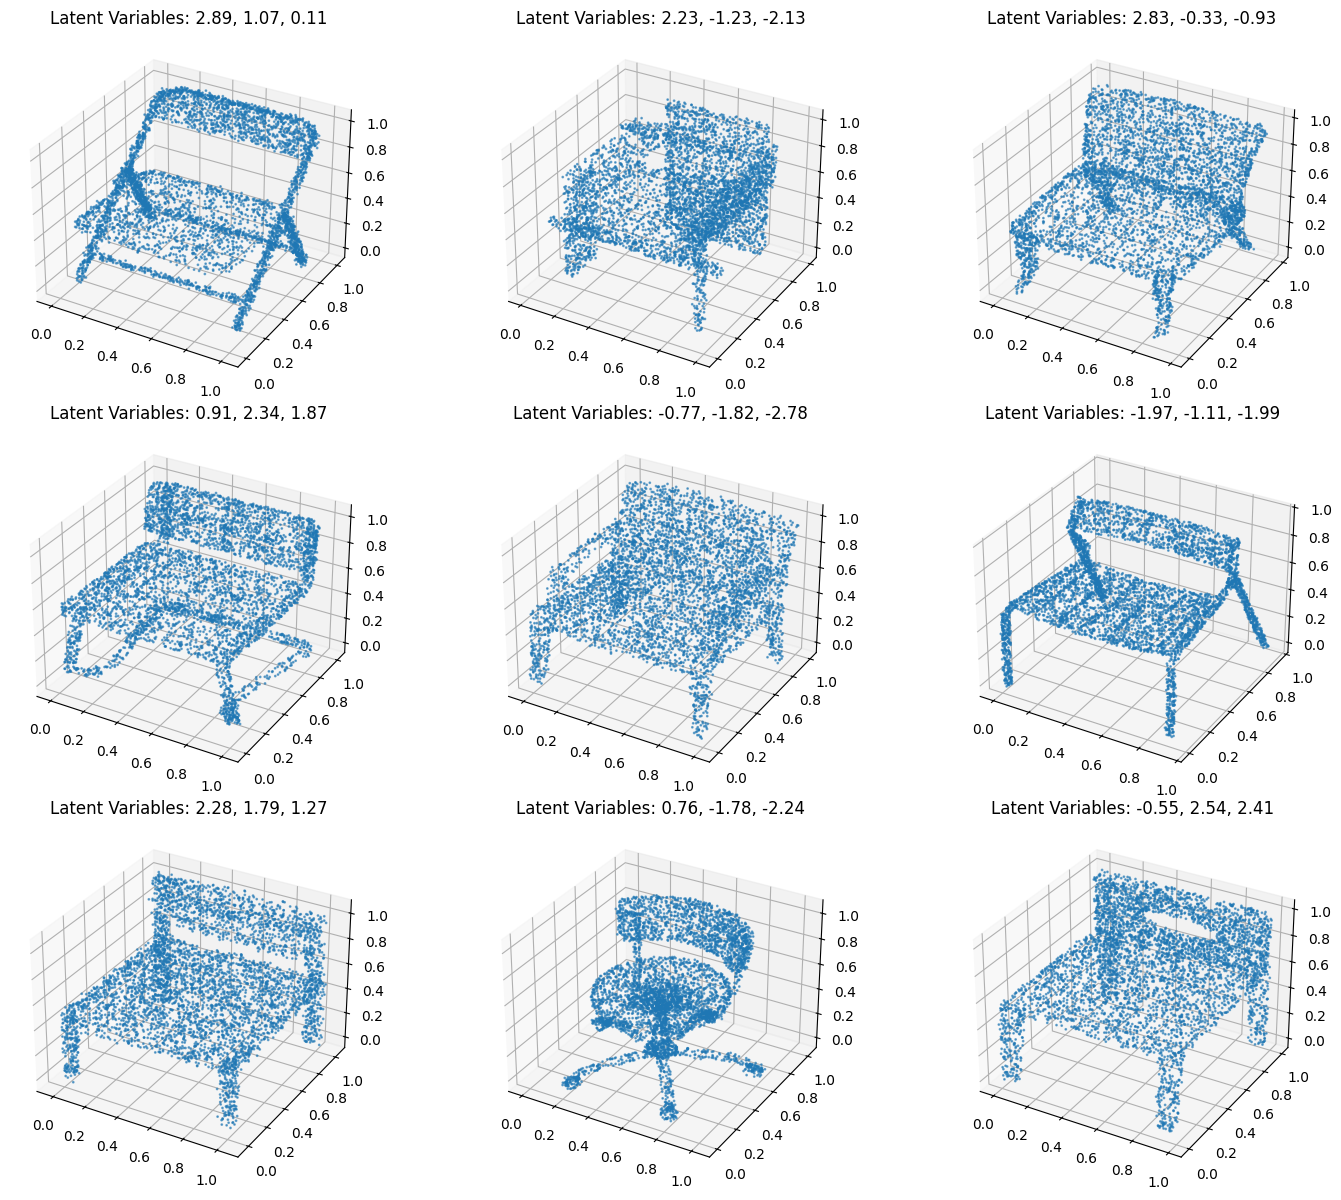

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    recon_batch = vae.decode(z)  # z をバッチの形状に変換

    # CPU上で detach して numpy に変換
    reconst = recon_batch.cpu().detach().numpy().reshape(-1)

    # num_points に基づいて点群を分割
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# 再構成誤差チェック using CD

Chamfer Distances: [0.19081169366836548, 0.12880927324295044, 0.15649110078811646, 0.14393199980258942, 0.15486890077590942, 0.2046431601047516, 0.17632372677326202, 0.13716700673103333, 0.16112864017486572]
Average Chamfer Distance: 0.1615750557846493


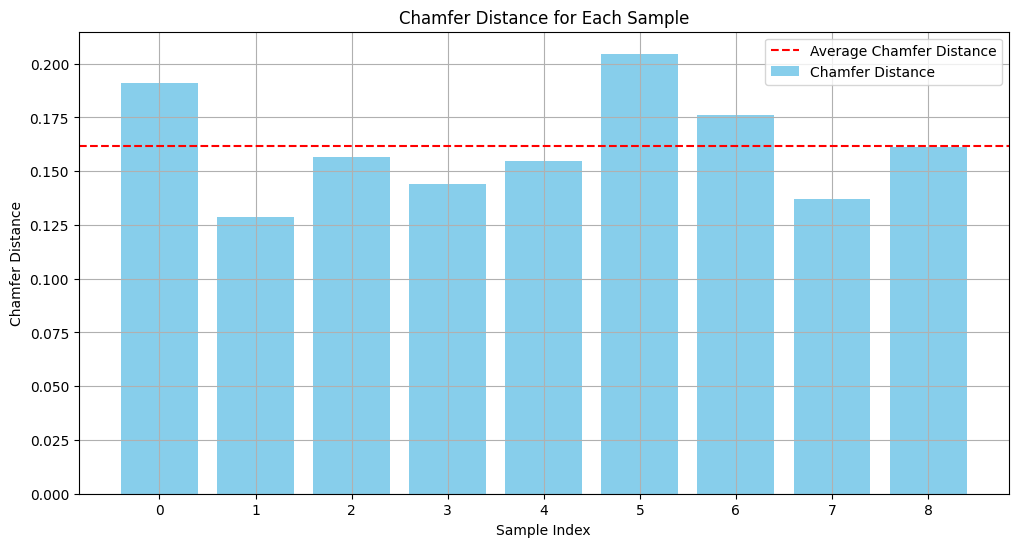

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

tensor([2.8877, 1.0675, 0.1087], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


tensor([ 2.2310, -1.2282, -2.1297], device='cuda:0')
tensor([ 2.8338, -0.3302, -0.9275], device='cuda:0')
tensor([0.9111, 2.3419, 1.8736], device='cuda:0')
tensor([-0.7697, -1.8180, -2.7755], device='cuda:0')
tensor([-1.9657, -1.1079, -1.9866], device='cuda:0')
tensor([2.2773, 1.7907, 1.2670], device='cuda:0')
tensor([ 0.7603, -1.7842, -2.2438], device='cuda:0')
tensor([-0.5499,  2.5368,  2.4112], device='cuda:0')
EMD Distances: [0.2145968456048384, 0.15585672329171674, 0.17873527520874571, 0.18210813826588346, 0.18687712948010976, 0.21615070727736402, 0.21254012261715094, 0.15667906516145963, 0.21705724919120234]
Average EMD Distance: 0.19117791734427456


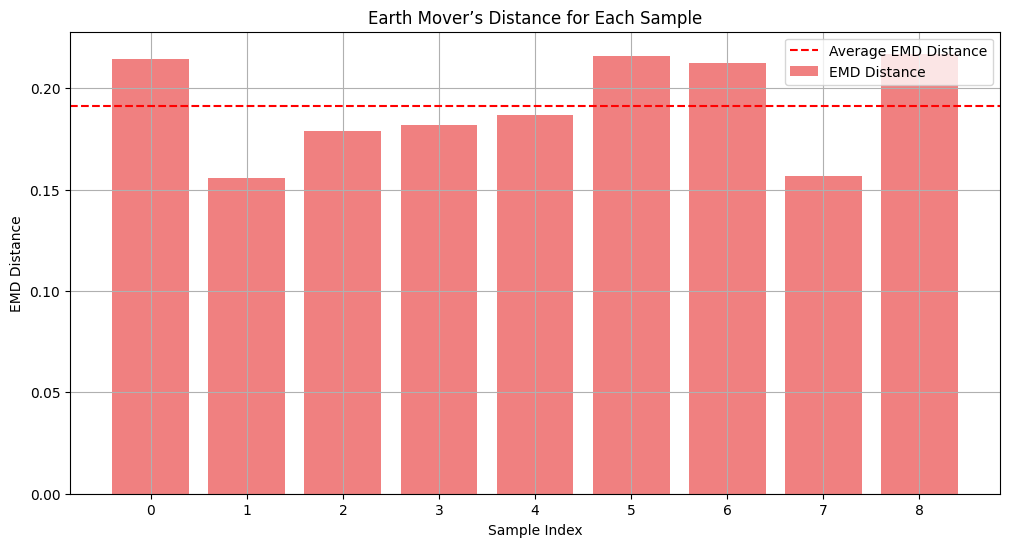

In [13]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    print(z_list[i])
    recon_batch = vae.decode(z_list[i])

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
